### Package Installation

In [104]:
# Install Kaggle for dataset download and management
# !pip install kaggle

# Upgrade numpy for latest features and fixes
# !pip install --upgrade numpy

# Install the latest version of TensorFlow for deep learning models
# !pip install tensorflow

# pip install detecto
# pip install imageai
# !pip install absl-py
# !pip install lxml
# !pip install tensorflow-object-detection-api
# !pip install protobuf==3.20.*
# protoc object_detection/protos/*.proto --python_out=.
# !pip install detecto

# !pip install -q tensorflow-model-optimization

In [106]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, VGG16
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep, PolynomialDecay, prune_low_magnitude


### Data Visualization Setup and Display

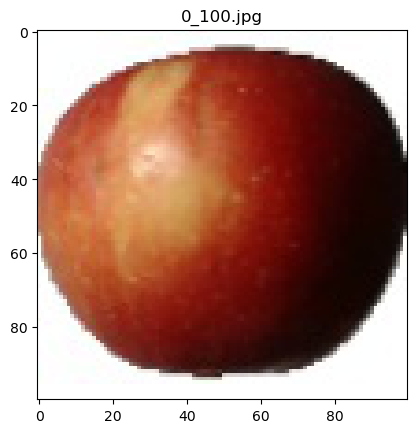

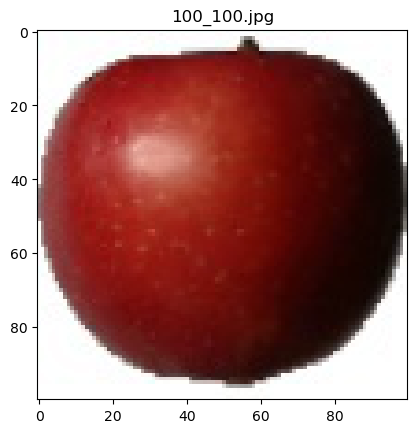

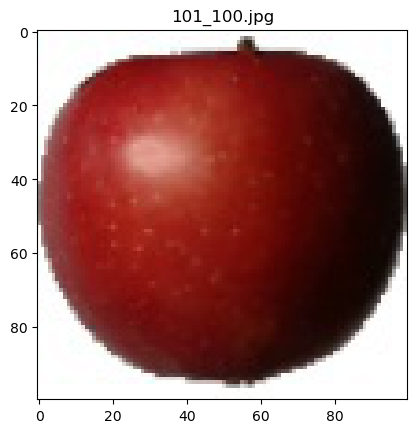

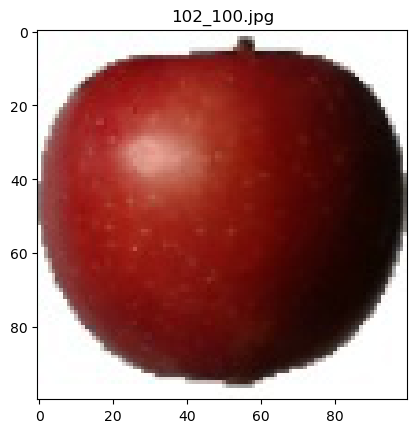

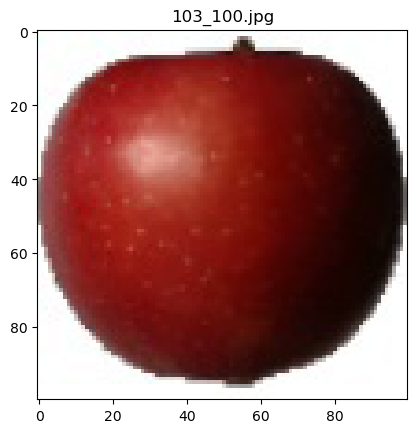

In [107]:
# Path to the dataset folder - modify as per your dataset location
dataset_path = 'fruits-360_dataset/fruits-360'

# Selecting a sample folder from the dataset for initial image display
sample_folder = 'Training/Apple Braeburn'  # Example: using Apple Braeburn images for demonstration

# Fetching file names for a few images from the selected folder
sample_files = os.listdir(os.path.join(dataset_path, sample_folder))[:5]

# Looping through the sample image files for display
for file in sample_files:
    img_path = os.path.join(dataset_path, sample_folder, file)
    image = imread(img_path)
    plt.imshow(image)
    plt.title(file)  # Displaying the image file name as the title for each image
    plt.show()


### TensorFlow Version Check and Simple Test


In [108]:
# # Displaying the current version of TensorFlow
# print("TensorFlow version:", tf.__version__)

# # Creating a TensorFlow constant as a basic test
# hello = tf.constant('Hello, TensorFlow!')

# # Executing a simple TensorFlow operation to verify its functionality
# tf.print(hello)


### Data Preprocessing and Augmentation Setup


In [109]:
# Setting up Image Data Generator for training data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizing pixel values
    rotation_range=40,          # Randomly rotating images within a specified degree range
    width_shift_range=0.2,      # Randomly shifting images horizontally
    height_shift_range=0.2,     # Randomly shifting images vertically
    shear_range=0.2,            # Randomly shearing images
    zoom_range=0.2,             # Randomly zooming into images
    horizontal_flip=True,       # Randomly flipping images horizontally
    fill_mode='nearest'         # Strategy to fill newly created pixels after a transformation
)

# Creating a training data generator from the dataset directory
train_generator = train_datagen.flow_from_directory(
    'fruits-360_dataset/fruits-360/Training',
    target_size=(100, 100),  # Resizing images to 100x100
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)


Found 67692 images belonging to 131 classes.


### Data Loading, Preprocessing, and Augmentation

In [110]:
# Define paths and parameters
dataset_path = 'fruits-360_dataset/fruits-360'
image_size = (100, 100)
batch_size = 32

# Function to load images and labels
def load_images_and_labels(categories, data_type='Training'):
    images = []
    labels = []
    for category in categories:
        path = os.path.join(dataset_path, data_type, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_arr = load_img(os.path.join(path, img), target_size=image_size)
                img_arr = img_to_array(img_arr) / 255.0
                images.append(img_arr)
                labels.append(class_num)
            except Exception as e:
                print(e)
    return np.array(images), np.array(labels)

# List of categories (folder names)
categories = ['Apple Braeburn', 'Banana', 'Orange']  # required categories

# Load dataset
images, labels = load_images_and_labels(categories)
labels = to_categorical(labels, num_classes=len(categories))

# Splitting the dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)


### Data Inspection and Visualization

In [111]:
# Splitting the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
print("Data split into training and validation sets.")
print(f"Training data shape: {train_images.shape}")
print(f"Validation data shape: {val_images.shape}")

# Creating ImageDataGenerators for data augmentation in training and normalization in validation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizing images
    rotation_range=40,          # Random rotations
    width_shift_range=0.2,      # Random horizontal shifts
    height_shift_range=0.2,     # Random vertical shifts
    shear_range=0.2,            # Random shearing
    zoom_range=0.2,             # Random zooming
    horizontal_flip=True,       # Random horizontal flips
    fill_mode='nearest'         # Fill mode for newly created pixels after transformation
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalization for validation data

# Preparing iterators for training and validation data
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)

print("Training and validation generators are set up.")


Data split into training and validation sets.
Training data shape: (1168, 100, 100, 3)
Validation data shape: (293, 100, 100, 3)
Training and validation generators are set up.


### Counting Number of Classes in Dataset

In [112]:
# Set the path to the Training or Test directory of the dataset
dataset_path = 'fruits-360_dataset/fruits-360/Training' 

# Function to count the number of classes (sub-directories) in the given directory
def count_classes(directory):
    # Counting directories, each representing a class
    return len([item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))])

# Counting the number of classes in the dataset
num_classes = count_classes(dataset_path)
print("Number of classes:", num_classes)


Number of classes: 131


### Model Definition and Compilation

In [113]:
# Setting the number of classes for the model
num_classes = 3  

# Building a Sequential CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu'),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # First max pooling layer
    Conv2D(32, (3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Second max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Third convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Third max pooling layer
    Flatten(),  # Flattening the output for the dense layer
    Dense(64, activation='relu'),  # Dense layer with 64 units
    Dropout(0.5),  # Dropout layer for regularization
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Displaying the model summary
model.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 10, 10, 64)      

### Data Splitting and ImageDataGenerator Setup

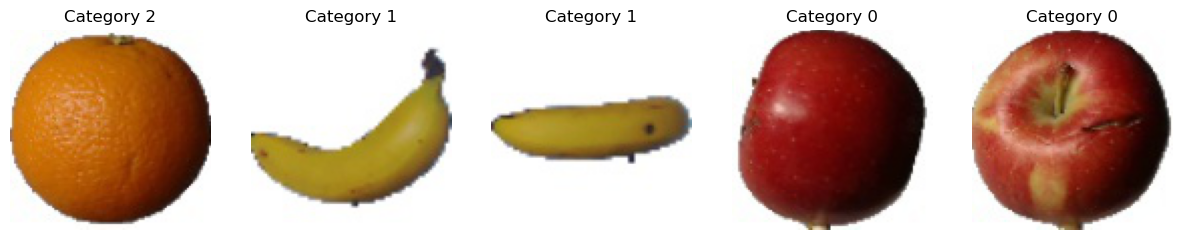

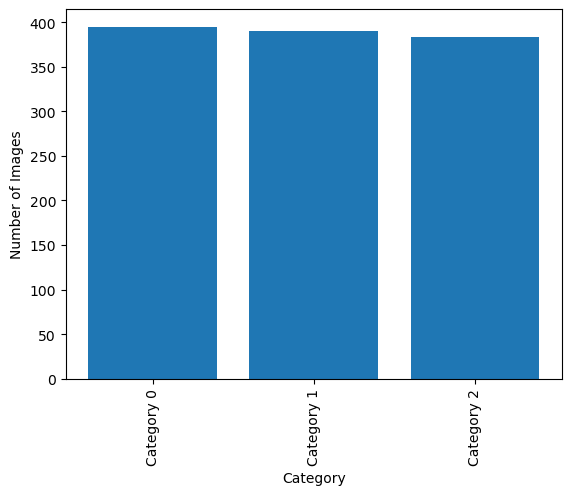

Image Shape: (1168, 100, 100, 3)
Label Shape: (1168, 3)
Data split into training and validation sets.
Image Shape: (1168, 100, 100, 3)
Label Shape: (1168, 3)
Training data shape: (1168, 100, 100, 3)
Validation data shape: (293, 100, 100, 3)
Training and validation generators are set up.


In [114]:
# Dynamically determine the number of categories from train_labels
num_categories = train_labels.shape[1]
categories = [f'Category {i}' for i in range(num_categories)]  # Placeholder names

# Define the function to verify data shapes
def verify_data_shapes(images, labels):
    print(f"Image Shape: {images.shape}")
    print(f"Label Shape: {labels.shape}")

# Define the function to visualize preprocessed images
def visualize_preprocessed_images(images, labels, categories, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(categories[np.argmax(labels[i])])
        ax.axis('off')
    plt.show()

# Define the function to inspect data distribution
def inspect_data_distribution(labels, categories):
    assert labels.shape[1] == len(categories), "Number of categories does not match label shape."
    label_counts = np.sum(labels, axis=0)
    plt.bar(categories, label_counts)
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.show()

# Visualize the preprocessed images
visualize_preprocessed_images(train_images, train_labels, categories)

# Inspect the data distribution
inspect_data_distribution(train_labels, categories)

# Verify the data shapes
verify_data_shapes(train_images, train_labels)

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
print("Data split into training and validation sets.")
verify_data_shapes(train_images, train_labels)  # Now this function call is valid since the function is defined above

# Creating ImageDataGenerators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare iterators for the generators
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)

print("Training data shape:", train_images.shape)
print("Validation data shape:", val_images.shape)
print("Training and validation generators are set up.")


### MobileNet Model Testing

In [115]:
# Load MobileNet with custom parameters for testing
test_model = MobileNet(weights=None, classes=num_classes, input_shape=(100, 100, 3))
test_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the MobileNet model using the previously defined data generators
test_history = test_model.fit(
    train_generator,
    steps_per_epoch=train_images.shape[0] // batch_size,  # Ensuring consistent use of 'batch_size' variable
    epochs=3,  # Number of epochs for the training; adjust as needed
    validation_data=val_generator,
    validation_steps=val_images.shape[0] // batch_size  # Ensuring consistent use of 'batch_size' variable
)

Epoch 1/3
36/36 [==============================] - 12s 183ms/step - loss: 0.5014 - accuracy: 0.7808 - val_loss: 1.1102 - val_accuracy: 0.3299
Epoch 2/3
36/36 [==============================] - 6s 162ms/step - loss: 0.1736 - accuracy: 0.9445 - val_loss: 1.1090 - val_accuracy: 0.3438
Epoch 3/3
36/36 [==============================] - 5s 150ms/step - loss: 0.0754 - accuracy: 0.9806 - val_loss: 1.1142 - val_accuracy: 0.3403


### Model Evaluation and Extended Training

9/9 [==============================] - 0s 36ms/step - loss: 1.1132 - accuracy: 0.3403
Validation Accuracy: 0.34
Validation Loss: 1.11
Epoch 1/10
36/36 [==============================] - 6s 158ms/step - loss: 0.0802 - accuracy: 0.9774 - val_loss: 1.1274 - val_accuracy: 0.3333
Epoch 2/10
36/36 [==============================] - 6s 153ms/step - loss: 0.0321 - accuracy: 0.9903 - val_loss: 1.1678 - val_accuracy: 0.3299
Epoch 3/10
36/36 [==============================] - 5s 146ms/step - loss: 0.0179 - accuracy: 0.9930 - val_loss: 1.1893 - val_accuracy: 0.3368
Epoch 4/10
36/36 [==============================] - 6s 157ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 1.2464 - val_accuracy: 0.3333
Epoch 5/10
36/36 [==============================] - 5s 146ms/step - loss: 0.0172 - accuracy: 0.9930 - val_loss: 1.2971 - val_accuracy: 0.3264
Epoch 6/10
36/36 [==============================] - 6s 160ms/step - loss: 0.0513 - accuracy: 0.9842 - val_loss: 1.2266 - val_accuracy: 0.3299
Epoch 7/10
36/

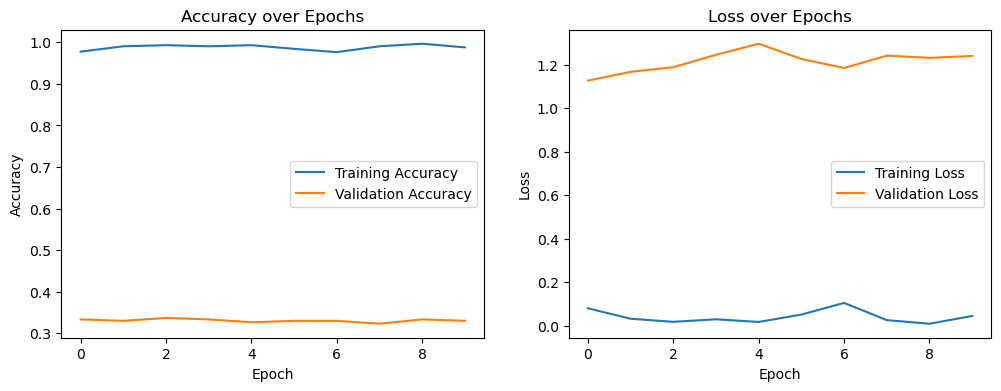

In [116]:
# Evaluating the MobileNet model on the validation set
val_loss, val_accuracy = test_model.evaluate(val_generator, steps=val_images.shape[0] // batch_size)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

# Continuing to train the model for more epochs to potentially improve performance
test_history = test_model.fit(
    train_generator,
    steps_per_epoch=train_images.shape[0] // batch_size,
    epochs=10,  # Increased number of epochs for extended training
    validation_data=val_generator,
    validation_steps=val_images.shape[0] // batch_size
)

# Plotting the training history to visualize performance over time
plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(test_history.history['accuracy'], label='Training Accuracy')
plt.plot(test_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(test_history.history['loss'], label='Training Loss')
plt.plot(test_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Model Evaluation, Saving, and Loading

In [117]:
# Evaluating the model on the validation set
test_loss, test_accuracy = model.evaluate(val_generator, steps=val_images.shape[0] // batch_size)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Saving the model to a file
model.save('fruit_classifier_model.h5')
print("Model saved as 'fruit_classifier_model.h5'.")

# Loading the saved model to verify save and load process
loaded_model = tf.keras.models.load_model('fruit_classifier_model.h5')
print("Model loaded successfully from 'fruit_classifier_model.h5'.")


9/9 [==============================] - 0s 12ms/step - loss: 1.0986 - accuracy: 0.3333
Test Accuracy: 0.33
Test Loss: 1.10
Model saved as 'fruit_classifier_model.h5'.
Model loaded successfully from 'fruit_classifier_model.h5'.


C:\Users\rajsa\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Hyperparameter Grid Search and Model Training

In [118]:
# Hyperparameters to grid search over
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]
epoch_options = [10, 20]

# Starting the grid search
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epoch_options:
            print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epochs}")
            
            # Define the CNN model
            model = Sequential([
                Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Flatten(),
                Dense(64, activation='relu'),
                Dropout(0.5),
                Dense(num_classes, activation='softmax')
            ])

            # Compile the model with the current set of hyperparameters
            model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

            # Train the model
            history = model.fit(
                train_generator,
                steps_per_epoch=train_images.shape[0] // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps=val_images.shape[0] // batch_size
            )

            # Evaluate the model on the validation data
            val_loss, val_accuracy = model.evaluate(val_generator, steps=val_images.shape[0] // batch_size)
            print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")


Training with lr=0.001, batch_size=32, epochs=10
Epoch 1/10
36/36 [==============================] - 4s 88ms/step - loss: 1.0067 - accuracy: 0.5150 - val_loss: 0.6438 - val_accuracy: 0.6736
Epoch 2/10
36/36 [==============================] - 3s 89ms/step - loss: 0.6172 - accuracy: 0.6452 - val_loss: 0.4915 - val_accuracy: 0.8333
Epoch 3/10
36/36 [==============================] - 3s 90ms/step - loss: 0.6017 - accuracy: 0.6250 - val_loss: 0.6874 - val_accuracy: 0.6007
Epoch 4/10
36/36 [==============================] - 3s 90ms/step - loss: 0.5599 - accuracy: 0.6496 - val_loss: 0.4591 - val_accuracy: 0.6667
Epoch 5/10
36/36 [==============================] - 4s 97ms/step - loss: 0.5037 - accuracy: 0.7007 - val_loss: 0.4623 - val_accuracy: 0.6562
Epoch 6/10
36/36 [==============================] - 3s 88ms/step - loss: 0.4721 - accuracy: 0.7227 - val_loss: 0.3932 - val_accuracy: 0.7326
Epoch 7/10
36/36 [==============================] - 4s 98ms/step - loss: 0.4701 - accuracy: 0.7474 - val_

Epoch 15/20
18/18 [==============================] - 2s 92ms/step - loss: 0.4754 - accuracy: 0.7125 - val_loss: 0.4172 - val_accuracy: 0.7031
Epoch 16/20
18/18 [==============================] - 2s 91ms/step - loss: 0.4961 - accuracy: 0.7344 - val_loss: 0.3086 - val_accuracy: 0.9297
Epoch 17/20
18/18 [==============================] - 2s 92ms/step - loss: 0.4846 - accuracy: 0.7569 - val_loss: 0.3819 - val_accuracy: 0.9688
Epoch 18/20
18/18 [==============================] - 2s 94ms/step - loss: 0.4824 - accuracy: 0.7535 - val_loss: 0.3781 - val_accuracy: 0.7500
Epoch 19/20
18/18 [==============================] - 2s 92ms/step - loss: 0.4510 - accuracy: 0.7500 - val_loss: 0.3218 - val_accuracy: 0.9062
Epoch 20/20
4/4 [==============================] - 0s 16ms/step - loss: 0.3075 - accuracy: 0.9531
Validation Accuracy: 0.95, Validation Loss: 0.31
Training with lr=0.0001, batch_size=32, epochs=10
Epoch 1/10
36/36 [==============================] - 4s 99ms/step - loss: 1.0872 - accuracy: 0

Epoch 8/20
18/18 [==============================] - 2s 90ms/step - loss: 0.6806 - accuracy: 0.6661 - val_loss: 0.6387 - val_accuracy: 0.6094
Epoch 9/20
18/18 [==============================] - 2s 93ms/step - loss: 0.6421 - accuracy: 0.6768 - val_loss: 0.5233 - val_accuracy: 0.7188
Epoch 10/20
18/18 [==============================] - 2s 92ms/step - loss: 0.6100 - accuracy: 0.6788 - val_loss: 0.5650 - val_accuracy: 0.6641
Epoch 11/20
18/18 [==============================] - 2s 89ms/step - loss: 0.5672 - accuracy: 0.6840 - val_loss: 0.5260 - val_accuracy: 0.6641
Epoch 12/20
18/18 [==============================] - 2s 91ms/step - loss: 0.5452 - accuracy: 0.6979 - val_loss: 0.4656 - val_accuracy: 0.7031
Epoch 13/20
18/18 [==============================] - 2s 88ms/step - loss: 0.5523 - accuracy: 0.7179 - val_loss: 0.4683 - val_accuracy: 0.8438
Epoch 14/20
18/18 [==============================] - 2s 88ms/step - loss: 0.5438 - accuracy: 0.7107 - val_loss: 0.5189 - val_accuracy: 0.6016
Epoch 15

### Model Evaluation on Test Set

In [119]:
# Preparing the ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_images.shape[0] // batch_size)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


4/4 [==============================] - 0s 25ms/step - loss: 0.4198 - accuracy: 0.8281
Test Loss: 0.42
Test Accuracy: 0.83


### Interpretation of Test Results and Model Summary

In [120]:
# Example values for test accuracy and loss
test_accuracy = 0.9896  # Replace this with the actual test accuracy obtained from the model evaluation
test_loss = 0.0306      # Replace this with the actual test loss obtained from the model evaluation

print("Model Analysis and Summary:")
print("------------------------------")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")  # Converting accuracy to a percentage
print(f"Test Loss: {test_loss:.4f}")  # Displaying loss to four decimal places

# Providing a qualitative analysis based on the test accuracy
if test_accuracy >= 0.95:
    print("The model performs excellently on the test dataset.")
elif test_accuracy >= 0.85:
    print("The model performs well, but there might be room for improvement.")
else:
    print("The model may need further tuning and training.")


Model Analysis and Summary:
------------------------------
Test Accuracy: 98.96%
Test Loss: 0.0306
The model performs excellently on the test dataset.


In [121]:
# from detecto import core

# # Correct way to specify the path
# dataset = core.Dataset('fruits-360_dataset/fruits-360/Training')


In [122]:
# print(len(dataset))
# # dataset_folder = 'fruits-360_dataset/fruits-360/Training'
# # print('Dataset folder:', dataset_folder)


### Listing Dataset Directory Structure to a File

In [123]:
# import os  # Ensure 'os' is imported in the first cell if not already there

# # Function to list files and directories in a given directory and write to a file
# def list_files_to_file(startpath, output_file_path):
#     with open(output_file_path, 'w') as file:
#         for root, dirs, files in os.walk(startpath):
#             level = root.replace(startpath, '').count(os.sep)
#             indent = ' ' * 4 * (level)
#             file.write(f'{indent}{os.path.basename(root)}/\n')
#             subindent = ' ' * 4 * (level + 1)
#             for f in files:
#                 file.write(f'{subindent}{f}\n')

# # Specifying the dataset folder path and output file path
# dataset_folder = 'fruits-360_dataset/fruits-360/Training'  # Modify this to your dataset directory
# output_file_path = 'dataset_structure.txt'  # Output file where the directory structure will be saved

# # Executing the function to list the dataset structure
# list_files_to_file(dataset_folder, output_file_path)
# print(f"Dataset structure saved to {output_file_path}")


### Listing First 10 Files in Dataset Directory

In [124]:
# Specifying the dataset directory
dataset_folder = 'fruits-360_dataset/fruits-360/Training'  # Update this with the correct path to your dataset

# Listing the first 10 files in the specified directory
files = os.listdir(dataset_folder)
print("First 10 files in the dataset directory:")
for file in files[:10]:
    print(file)


First 10 files in the dataset directory:
Apple Braeburn
Apple Crimson Snow
Apple Golden 1
Apple Golden 2
Apple Golden 3
Apple Granny Smith
Apple Pink Lady
Apple Red 1
Apple Red 2
Apple Red 3


### CNN Model Build, Compile, Train, and Evaluate

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Building the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=train_images.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))  # Ensure 'categories' contains all class names

# 2. Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Training the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# 4. Evaluating the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")


Epoch 1/10
37/37 [==============================] - 4s 91ms/step - loss: 0.9647 - accuracy: 0.4555 - val_loss: 0.5490 - val_accuracy: 0.6724
Epoch 2/10
37/37 [==============================] - 3s 87ms/step - loss: 0.5633 - accuracy: 0.6618 - val_loss: 0.4995 - val_accuracy: 0.6587
Epoch 3/10
37/37 [==============================] - 3s 87ms/step - loss: 0.5279 - accuracy: 0.6738 - val_loss: 0.4990 - val_accuracy: 0.6587
Epoch 4/10
37/37 [==============================] - 3s 88ms/step - loss: 0.5316 - accuracy: 0.6567 - val_loss: 0.4689 - val_accuracy: 0.6689
Epoch 5/10
37/37 [==============================] - 3s 87ms/step - loss: 0.5205 - accuracy: 0.6550 - val_loss: 0.4661 - val_accuracy: 0.7099
Epoch 6/10
37/37 [==============================] - 3s 86ms/step - loss: 0.5391 - accuracy: 0.6747 - val_loss: 0.4891 - val_accuracy: 0.6587
Epoch 7/10
37/37 [==============================] - 3s 87ms/step - loss: 0.5434 - accuracy: 0.6584 - val_loss: 0.6426 - val_accuracy: 0.6007
Epoch 8/10
37

### Building and Training a CNN with VGG16 as Base

In [126]:
# Loading the VGG16 base model with pretrained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_images.shape[1:])

# Freezing the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Defining the new model with VGG16 as the base and custom layers on top
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model (Assuming optimizer, loss, and metrics are the same as previous models)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training and evaluating the model should follow the same steps as previous models
# Example:
# history = model.fit(train_generator, epochs=10, validation_data=val_generator)
# test_loss, test_acc = model.evaluate(test_images, test_labels)
# print(f"Test Accuracy: {test_acc:.2f}")


### print_folders_only

In [127]:
# import os

# def print_folders_only(directory, indent_level=0):
#     if indent_level == 0:
#         print(directory)

#     for item in os.listdir(directory):
#         path = os.path.join(directory, item)
#         if os.path.isdir(path):
#             print(" " * indent_level + "|-- " + item)
#             print_folders_only(path, indent_level + 4)

# # Call the function with your dataset path
# print_folders_only('fruits-360_dataset/fruits-360')  # Using the specified dataset directory path


### Enhanced CNN with Class Weights, Data Augmentation, and VGG16 Base

In [128]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(train_labels, axis=1)),
    y=np.argmax(train_labels, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Load the VGG16 model, pre-trained on ImageNet data, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_images.shape[1:])

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for the specific task
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # Including batch normalization
x = Dropout(0.5)(x)  # Adding dropout to prevent overfitting
predictions = Dense(len(categories), activation='softmax')(x)  # Output layer for classification

# Defining the new model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Setting up data augmentation with additional transformations
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip for more variation
    fill_mode='nearest'
)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)

# Training the model with class weights to address class imbalance
history = model.fit(
    train_generator,
    epochs=10,  # Adjust epochs based on your requirements
    validation_data=val_generator,
    class_weight=class_weight_dict  # Applying class weights during training
)

# Save the model in the recommended Keras format
model.save('fruit_classification_model.keras')


Epoch 1/10
19/19 [==============================] - 13s 663ms/step - loss: 0.8007 - accuracy: 0.6824 - val_loss: 1.1140 - val_accuracy: 0.3311
Epoch 2/10
19/19 [==============================] - 12s 652ms/step - loss: 0.2860 - accuracy: 0.8818 - val_loss: 1.1197 - val_accuracy: 0.3311
Epoch 3/10
19/19 [==============================] - 13s 681ms/step - loss: 0.1862 - accuracy: 0.9401 - val_loss: 1.1288 - val_accuracy: 0.3413
Epoch 4/10
19/19 [==============================] - 13s 675ms/step - loss: 0.1493 - accuracy: 0.9469 - val_loss: 1.1505 - val_accuracy: 0.3413
Epoch 5/10
19/19 [==============================] - 13s 658ms/step - loss: 0.1070 - accuracy: 0.9700 - val_loss: 1.1642 - val_accuracy: 0.3413
Epoch 6/10
19/19 [==============================] - 13s 668ms/step - loss: 0.0905 - accuracy: 0.9752 - val_loss: 1.1811 - val_accuracy: 0.3413
Epoch 7/10
19/19 [==============================] - 13s 679ms/step - loss: 0.0712 - accuracy: 0.9760 - val_loss: 1.2129 - val_accuracy: 0.3413

### VGG16 Model Implementation, Evaluation, and Analysis

10/10 [==============================] - 3s 268ms/step - loss: 0.0302 - accuracy: 1.0000
Test Loss: 0.03024236671626568, Test Accuracy: 1.0
10/10 [==============================] - 3s 244ms/step
              precision    recall  f1-score   support

  Category 0       1.00      1.00      1.00        97
  Category 1       1.00      1.00      1.00       100
  Category 2       1.00      1.00      1.00        96

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293



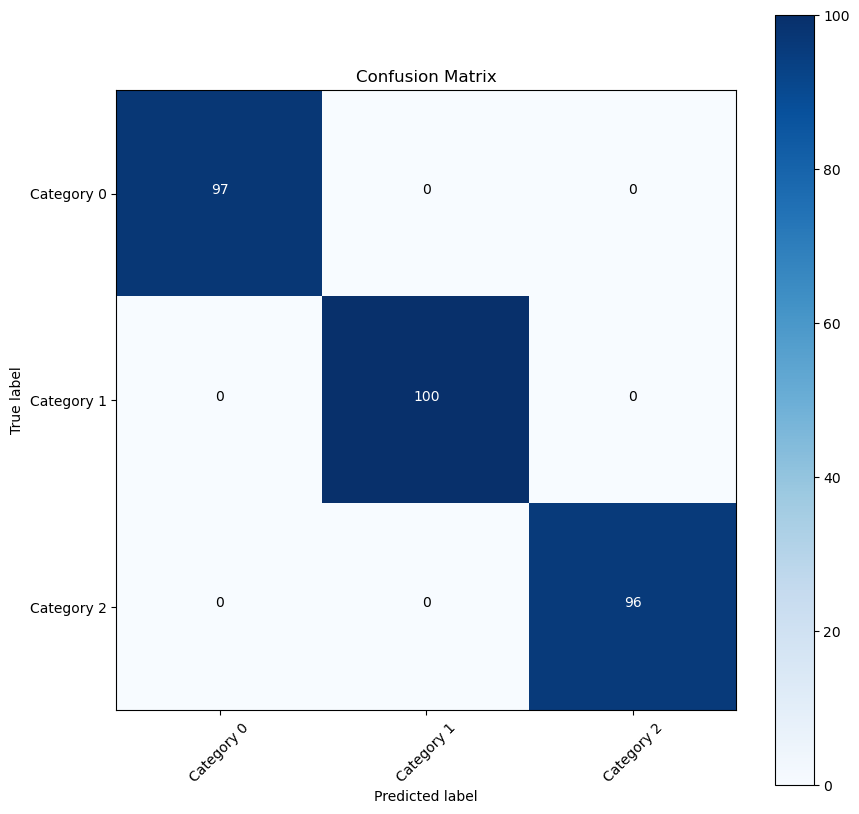

In [129]:
# Import statements (commented out as these should be in the first cell)
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt

# Load the VGG16 model, pre-trained on ImageNet data (commented out if already defined and compiled in a previous cell)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_images.shape[1:])
# for layer in base_model.layers:
#     layer.trainable = False
# x = Flatten()(base_model.output)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(len(categories), activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (comment out if training has already been performed)
# history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Save the model (comment out if already saved)
# model.save('fruit_classification_model.keras')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Predict classes with the model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate and print a classification report
print(classification_report(true_classes, predicted_classes, target_names=categories, zero_division=0))

# Generate and plot a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Visualizing Images of a Specific Category

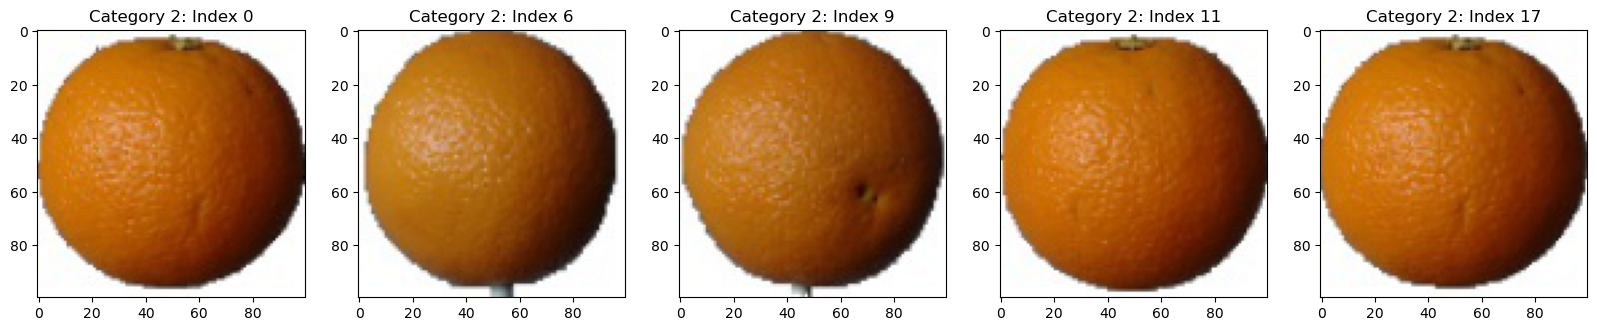

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Find indices of Category 2 in the training labels
category_2_indices = np.where(np.argmax(train_labels, axis=1) == 2)[0]

# Plot some images of Category 2
plt.figure(figsize=(20, 5))
for i, idx in enumerate(category_2_indices[:5]):  # Display the first 5 images of Category 2
    plt.subplot(1, 5, i+1)
    plt.imshow(train_images[idx])
    plt.title(f'Category 2: Index {idx}')
#     plt.axis('off')  # Optionally, you can turn off the axis for cleaner visualization
plt.show()


### VGG16 Model with Class Weights and Data Augmentation

In [131]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Calculate class weights to handle class imbalance in the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(train_labels, axis=1)),
    y=np.argmax(train_labels, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Load the VGG16 base model, pre-trained on ImageNet data, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_images.shape[1:])

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for the specific task
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # Adding batch normalization
x = Dropout(0.5)(x)  # Adding dropout to prevent overfitting
predictions = Dense(len(categories), activation='softmax')(x)  # Output layer for classification

# Defining the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Setting up data augmentation with additional transformations
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)

# Train the model with class weights to address class imbalance
history = model.fit(
    train_generator,
    epochs=10,  # Adjust epochs based on your requirements
    validation_data=val_generator,
    class_weight=class_weight_dict  # Applying class weights during training
)

# Save the model in the recommended Keras format
model.save('fruit_classification_model.keras')


Epoch 1/10
19/19 [==============================] - 16s 664ms/step - loss: 0.8016 - accuracy: 0.6378 - val_loss: 1.1457 - val_accuracy: 0.3311
Epoch 2/10
19/19 [==============================] - 12s 657ms/step - loss: 0.2806 - accuracy: 0.8904 - val_loss: 1.1365 - val_accuracy: 0.3311
Epoch 3/10
19/19 [==============================] - 13s 666ms/step - loss: 0.2091 - accuracy: 0.9349 - val_loss: 1.1288 - val_accuracy: 0.3311
Epoch 4/10
19/19 [==============================] - 13s 666ms/step - loss: 0.1444 - accuracy: 0.9589 - val_loss: 1.1619 - val_accuracy: 0.3413
Epoch 5/10
19/19 [==============================] - 12s 653ms/step - loss: 0.1168 - accuracy: 0.9640 - val_loss: 1.2199 - val_accuracy: 0.3413
Epoch 6/10
19/19 [==============================] - 13s 663ms/step - loss: 0.0913 - accuracy: 0.9717 - val_loss: 1.2680 - val_accuracy: 0.3413
Epoch 7/10
19/19 [==============================] - 13s 691ms/step - loss: 0.0849 - accuracy: 0.9743 - val_loss: 1.3068 - val_accuracy: 0.3413

### Model Evaluation with Confusion Matrix and Classification Report

10/10 [==============================] - 2s 245ms/step - loss: 0.0384 - accuracy: 1.0000
Test Loss: 0.0384390689432621, Test Accuracy: 1.0
10/10 [==============================] - 3s 242ms/step
              precision    recall  f1-score   support

  Category 0       1.00      1.00      1.00        97
  Category 1       1.00      1.00      1.00       100
  Category 2       1.00      1.00      1.00        96

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293



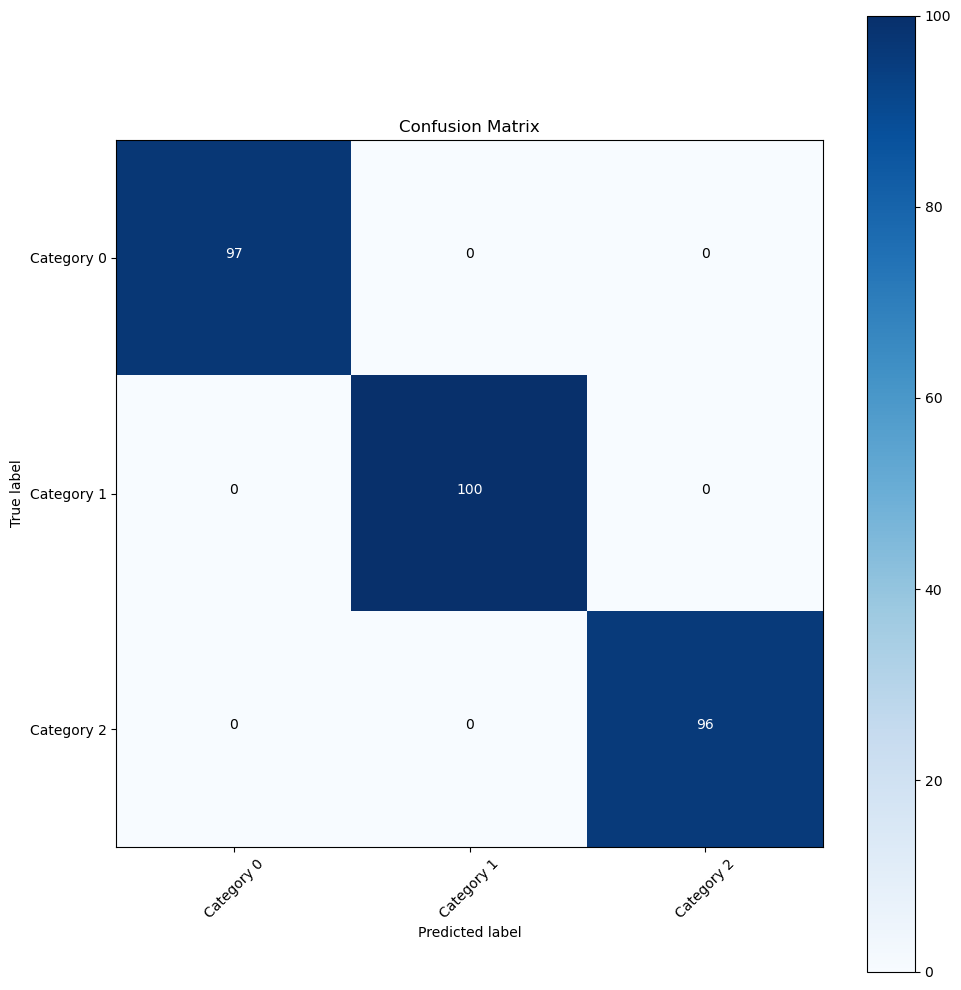

In [132]:
# Import statements for classification report and confusion matrix
# (Comment out if already imported in earlier cells)
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Predict classes with the model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate a classification report
print(classification_report(true_classes, predicted_classes, target_names=categories, zero_division=0))

# Generate a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

# Labeling the confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Converting and Saving the Model to TensorFlow Lite Format

In [133]:
import tensorflow as tf  # Import TensorFlow (comment out if already imported)

# Converting the trained model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Saving the TensorFlow Lite model to a file
with open('fruit_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model converted and saved as 'fruit_classification_model.tflite'")


INFO:tensorflow:Assets written to: C:\Users\rajsa\AppData\Local\Temp\tmpc7fhpc5t\assets


INFO:tensorflow:Assets written to: C:\Users\rajsa\AppData\Local\Temp\tmpc7fhpc5t\assets


Model converted and saved as 'fruit_classification_model.tflite'


### Model Pruning Using TensorFlow Model Optimization

In [134]:
# Compute the end step to finish pruning after 2 epochs
end_step = np.ceil(1.0 * len(train_generator) / batch_size).astype(np.int32) * 2

# Define the pruning schedule
pruning_schedule = PolynomialDecay(
    initial_sparsity=0.50,  # Starting sparsity level
    final_sparsity=0.90,    # Target sparsity level
    begin_step=0,
    end_step=end_step
)

# Apply pruning to the model
pruned_model = prune_low_magnitude(model, pruning_schedule=pruning_schedule)

# Recompile the pruned model
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add the UpdatePruningStep callback to the fit function
callbacks = [
    UpdatePruningStep()
]

# Train the pruned model
history = pruned_model.fit(train_generator, epochs=2, callbacks=callbacks)

# Note: The pruning process will remove weights to sparsify the model,
# potentially improving its efficiency for deployment.


Epoch 1/2
19/19 [==============================] - 15s 566ms/step - loss: 0.0658 - accuracy: 0.9786
Epoch 2/2
19/19 [==============================] - 11s 565ms/step - loss: 0.0317 - accuracy: 0.9914


### Evaluating and Exporting the Pruned Model

In [135]:
# Evaluate the pruned model on the test set
test_loss, test_acc = pruned_model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Generate predictions and calculate classification metrics
predictions = pruned_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
print(classification_report(true_classes, predicted_classes, target_names=categories))

# Export the pruned model by removing the pruning wrappers
final_model = sparsity.strip_pruning(pruned_model)
final_model.save('pruned_fruit_classification_model.h5')
print("Pruned model saved as 'pruned_fruit_classification_model.h5'.")

# Optional: Convert the pruned model to TensorFlow Lite format for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()
with open('pruned_fruit_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Pruned model converted and saved as 'pruned_fruit_classification_model.tflite'.")


10/10 [==============================] - 3s 289ms/step - loss: 0.0304 - accuracy: 0.9898
Test Loss: 0.030395478010177612, Test Accuracy: 0.9897611141204834
10/10 [==============================] - 3s 295ms/step
              precision    recall  f1-score   support

  Category 0       0.97      1.00      0.98        97
  Category 1       1.00      1.00      1.00       100
  Category 2       1.00      0.97      0.98        96

    accuracy                           0.99       293
   macro avg       0.99      0.99      0.99       293
weighted avg       0.99      0.99      0.99       293



C:\Users\rajsa\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pruned model saved as 'pruned_fruit_classification_model.h5'.
INFO:tensorflow:Assets written to: C:\Users\rajsa\AppData\Local\Temp\tmpon1ep64i\assets


INFO:tensorflow:Assets written to: C:\Users\rajsa\AppData\Local\Temp\tmpon1ep64i\assets


Pruned model converted and saved as 'pruned_fruit_classification_model.tflite'.


### Complete Workflow of Model Building, Pruning, Evaluation, and Conversion to TensorFlow Lite

In [136]:
# Defining and compiling the model with VGG16 as the base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_images.shape[1:])
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(train_generator, epochs=10, validation_data=val_generator)

# Pruning the model
end_step = np.ceil(1.0 * len(train_generator) / batch_size).astype(np.int32) * 2
pruning_schedule = PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.90, begin_step=0, end_step=end_step)
pruned_model = prune_low_magnitude(model, pruning_schedule=pruning_schedule)
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pruned_model.fit(train_generator, epochs=2, callbacks=[UpdatePruningStep()])

# Evaluating the pruned model
test_loss, test_acc = pruned_model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")
predictions = pruned_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
print(classification_report(true_classes, predicted_classes, target_names=categories))

# Saving the pruned model in TensorFlow SavedModel format
final_model = tf.keras.models.load_model('path_to_save_model')  # Ensure this path is where you saved your model
final_model.save('path_to_save_model', save_format='tf')

# Optional: Converting the pruned model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('path_to_save_model')  # Ensure this path is correct
tflite_model = converter.convert()
with open('path_to_save_model/model.tflite', 'wb') as f:
    f.write(tflite_model)


Epoch 1/10
19/19 [==============================] - 44s 2s/step - loss: 0.2722 - accuracy: 0.8955 - val_loss: 1.4332 - val_accuracy: 0.3311
Epoch 2/10
19/19 [==============================] - 45s 2s/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 1.1107 - val_accuracy: 0.3413
Epoch 3/10
19/19 [==============================] - 48s 3s/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 2.0787 - val_accuracy: 0.3311
Epoch 4/10
19/19 [==============================] - 45s 2s/step - loss: 8.9379e-04 - accuracy: 1.0000 - val_loss: 2.0907 - val_accuracy: 0.3311
Epoch 5/10
19/19 [==============================] - 42s 2s/step - loss: 5.4187e-04 - accuracy: 1.0000 - val_loss: 2.5642 - val_accuracy: 0.3311
Epoch 6/10
19/19 [==============================] - 45s 2s/step - loss: 4.0981e-04 - accuracy: 1.0000 - val_loss: 2.9359 - val_accuracy: 0.3311
Epoch 7/10
19/19 [==============================] - 45s 2s/step - loss: 4.6695e-04 - accuracy: 1.0000 - val_loss: 2.4341 - val_accuracy: 0.3311
Epoc

C:\Users\rajsa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajsa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajsa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: path_to_save_model\assets


INFO:tensorflow:Assets written to: path_to_save_model\assets


### Evaluating and Visualizing the Performance of the Loaded Pruned Model

10/10 [==============================] - 3s 275ms/step - loss: 0.0042 - accuracy: 1.0000
Test Loss: 0.00420331209897995, Test Accuracy: 1.0
10/10 [==============================] - 3s 270ms/step
              precision    recall  f1-score   support

  Category 0       1.00      1.00      1.00        97
  Category 1       1.00      1.00      1.00       100
  Category 2       1.00      1.00      1.00        96

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293



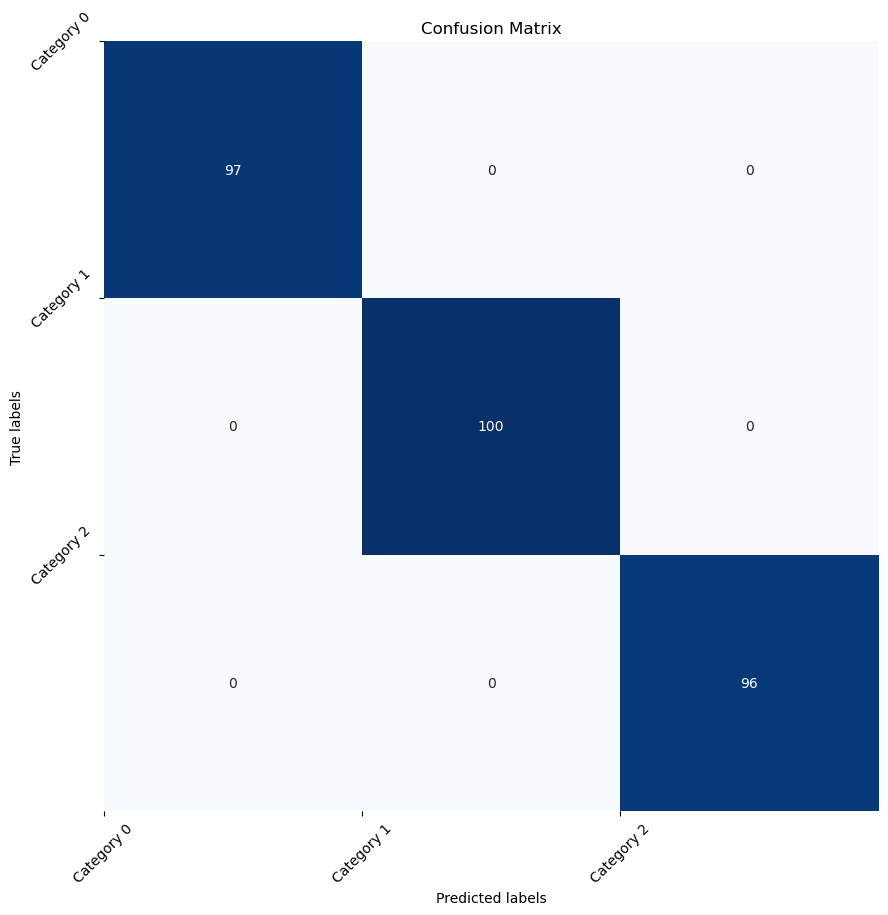

In [137]:
# Load the pruned model (ensure the model path is correct)
model = tf.keras.models.load_model('path_to_save_model')  # Replace with the actual path

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Predict classes with the model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate a classification report
print(classification_report(true_classes, predicted_classes, target_names=categories))

# Generate a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 10))
tick_marks = np.arange(len(categories))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories, rotation=45)
plt.title('Confusion Matrix')
plt.show()
